In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'lib')))
from renormalization import find_Jc, dH_dH, rg_step
from utils import build_J

In [2]:
def magnetization(J0, a, Jc, D0=1000, n_steps=10, eps=1e-6):
    # If we start on the disordered side, magnetization is zero.
    M_sink = 1.0 if J0 > Jc else 0.0
    if M_sink == 0.0:
        return 0.0

    # Length-rescaling factor and spatial dimension
    b = 3.0
    d_dim = 1.0

    J = build_J(J0, a, D0)

    prod_R = 1.0
    k = 0

    for step in range(n_steps):
        # dH'/dH at this level
        dH = dH_dH(J, eps=eps)
        if not np.isfinite(dH) or dH <= 0.0:
            break
        prod_R *= dH
        k = step + 1

        # Next RG step. If the range collapses (r_max < 1) we stop.
        D = len(J) - 1
        r_max = (D - 2) // 3
        if r_max < 1:
            break
        J = rg_step(J)

    if k == 0:
        return 0.0

    scale = (b ** (-d_dim)) ** k
    M0 = scale * prod_R * M_sink
    return float(M0)

In [3]:
a = 1

Jc = find_Jc(a, Jlow=1e-2, Jhigh=1e2,
     max_steps=6, max_dist_final=9, tol=1e-5,
     growth_threshold=1e4, decay_threshold=1e-4)
print("Critical J =", Jc)

J = Jc + .001
M = magnetization(J, a, Jc, D0=1000, n_steps=6)
print("M =", M)

Critical J = 0.12799049526453016
M = 0.04294421618516515


Jc = 0.4238417166098952


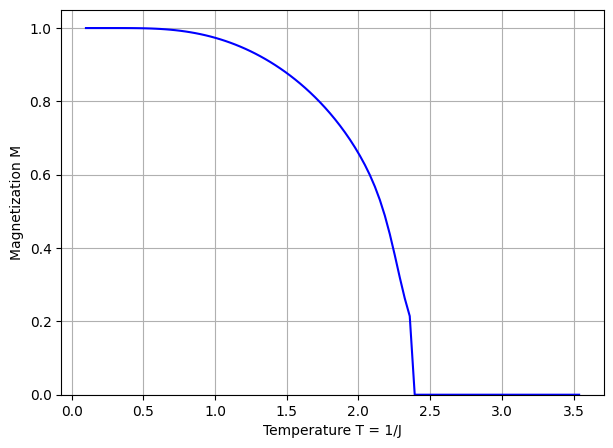

In [5]:
# Parameters
a = 1.5
Jc = find_Jc(a=a, Jlow=1e-2, Jhigh=1e2,
             max_steps=8, max_dist_final=6, tol=1e-6,
             growth_threshold=1e4, decay_threshold=1e-4)

print(f"Jc = {Jc}")
T_values = np.linspace(0.1, 1.5/Jc, 100)
J_values = 1.0 / T_values

M_values = [magnetization(J0, a, Jc,
                          D0=1000,
                          n_steps=7,
                          eps=1e-8) for J0 in J_values]

plt.figure(figsize=(7, 5))
plt.plot(T_values, M_values, 'b-')
plt.xlabel("Temperature T = 1/J")
plt.ylabel("Magnetization M")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

Processing a = 0.0
Processing a = 0.2
Processing a = 0.4
Processing a = 0.6


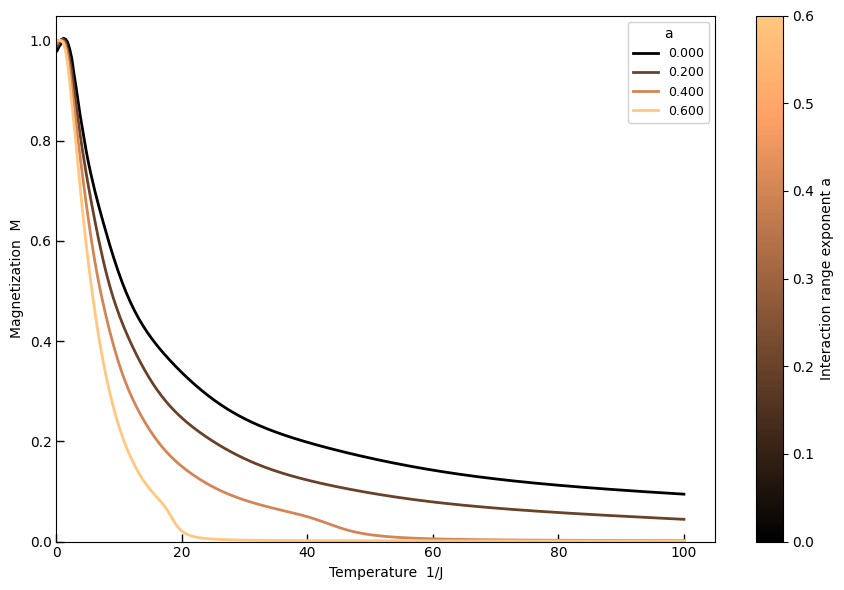

In [7]:
from matplotlib import cm

a_values = np.array([0.0 , 0.2, 0.4, 0.6])
data_by_a = []

for a in a_values:
    print(f"Processing a = {a}")

    if a < 0.8:
        Jc = 1e-10
        T_arr = np.linspace(0.10, 100, 300)
        J_arr = 1.0 / T_arr
    else:
        Jc = find_Jc(
            a=a,
            Jlow=1e-2, Jhigh=1e2,
            max_steps=10,
            max_dist_final=6,
            tol=1e-6,
            growth_threshold=1e4,
            decay_threshold=1e-4
        )
        T_arr = np.linspace(0.10, 1.1 / Jc, 100)
        J_arr = 1.0 / T_arr


    M_arr = []
    for J0 in J_arr:
        T = 1/J0
        if T < 0.8:
            max_k = 8
        else:
            max_k = 10
        M_arr.append(magnetization(J0, a, Jc, D0=2000, n_steps=max_k, eps=1e-8))    
    M_arr = np.array(M_arr)

    data_by_a.append(list(zip(T_arr, M_arr)))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for a, tuples_a in zip(a_values, data_by_a):
    T_arr = np.array([x[0] for x in tuples_a])
    M_arr = np.array([x[1] for x in tuples_a])
    ax.plot(T_arr, M_arr, label=f"{a:.3f}", color=cmap(norm(a)), linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction range exponent a')
ax.set_xlabel('Temperature  1/J')
ax.set_ylabel('Magnetization  M')
ax.set_xlim(0, None)
ax.set_ylim(0, 1.05)
ax.legend(title='a', loc='upper right', fontsize=9, framealpha=.9)
ax.tick_params(axis='both', which='major', direction='in', width=1, length=6)
plt.tight_layout()
plt.show()

Processing a = 0.0
Processing a = 0.2
Processing a = 0.4
Processing a = 0.6
Processing a = 0.8
Processing a = 1.0
Processing a = 1.2
Processing a = 1.4
Processing a = 1.6
Processing a = 1.8
Processing a = 1.9
Processing a = 2.0


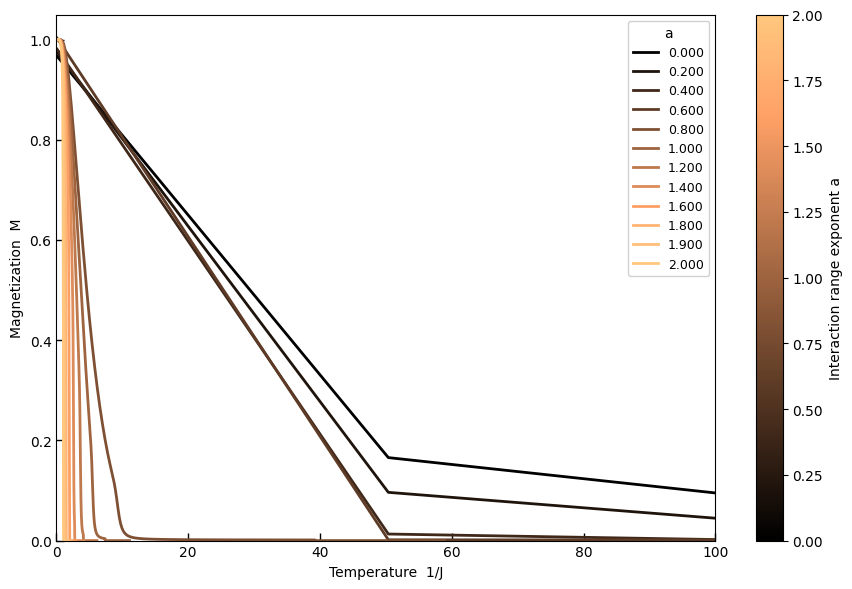

In [4]:
from matplotlib import cm

a_values = np.array([0.0 , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 1.9, 2.0 ])
data_by_a = []

for a in a_values:
    print(f"Processing a = {a}")

    Jc = find_Jc(
        a=a,
        Jlow=1e-5, Jhigh=1e2,
        max_steps=10,
        max_dist_final=6,
        tol=1e-6,
        growth_threshold=1e4,
        decay_threshold=1e-4
    )

    T_arr = np.linspace(0.10, 1.5 / Jc, 300)
    J_arr = 1.0 / T_arr

    M_arr = np.array([
        magnetization(J0, a, Jc, D0=2000, n_steps=10, eps=1e-8)
        for J0 in J_arr
    ])

    data_by_a.append(list(zip(T_arr, M_arr)))

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

for a, tuples_a in zip(a_values, data_by_a):
    T_arr = np.array([x[0] for x in tuples_a])
    M_arr = np.array([x[1] for x in tuples_a])
    ax.plot(T_arr, M_arr, label=f"{a:.3f}", color=cmap(norm(a)), linewidth=2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, ax=ax, label='Interaction range exponent a')
ax.set_xlabel('Temperature  1/J')
ax.set_ylabel('Magnetization  M')
ax.set_xlim(0, 100)
ax.set_ylim(0, 1.05)
ax.legend(title='a', loc='upper right', fontsize=9, framealpha=.9)
ax.tick_params(axis='both', which='major', direction='in', width=1, length=6)
plt.tight_layout()
plt.show()

In [ ]:
# Save data for each a to its own file
for a, tuples_a in zip(a_values, data_by_a):
    T_arr = np.array([x[0] for x in tuples_a])
    M_arr = np.array([x[1] for x in tuples_a])
    out = np.column_stack((T_arr, M_arr))

    filename = f"../data/magnetization/magnetization_a_{a:.3f}.txt"
    np.savetxt(
        filename, out,
        header="T\tM",
        fmt="%.12e",
        comments=""
    )
    print("Saved:", filename)

In [3]:
# Load data for each a from its own file
import numpy as np

# a-values used originally
a_values = np.array([0.0 , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 1.9, 2.0])

data_by_a = []

for a in a_values:
    filename = f"../data/magnetization/magnetization_a_{a:.3f}.txt"
    print("Loading:", filename)

    # If file has a header "T M", skiprows=1 handles it.
    arr = np.loadtxt(filename, skiprows=1)

    T_arr = arr[:, 0]
    M_arr = arr[:, 1]

    data_by_a.append(list(zip(T_arr, M_arr)))

Loading: ../data/magnetization/magnetization_a_0.000.txt
Loading: ../data/magnetization/magnetization_a_0.200.txt
Loading: ../data/magnetization/magnetization_a_0.400.txt
Loading: ../data/magnetization/magnetization_a_0.600.txt
Loading: ../data/magnetization/magnetization_a_0.800.txt
Loading: ../data/magnetization/magnetization_a_1.000.txt
Loading: ../data/magnetization/magnetization_a_1.200.txt
Loading: ../data/magnetization/magnetization_a_1.400.txt
Loading: ../data/magnetization/magnetization_a_1.600.txt
Loading: ../data/magnetization/magnetization_a_1.800.txt
Loading: ../data/magnetization/magnetization_a_1.900.txt
Loading: ../data/magnetization/magnetization_a_2.000.txt


In [39]:
# Nearest-neighbor calculation
from a0 import *

Ts, Ms = sweep_magnetization(0.01, 100, 300)

/var/folders/p_/j__hv0j95yv8xknt5_nvt4pw0000gn/T/ipykernel_17411/2736731763.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


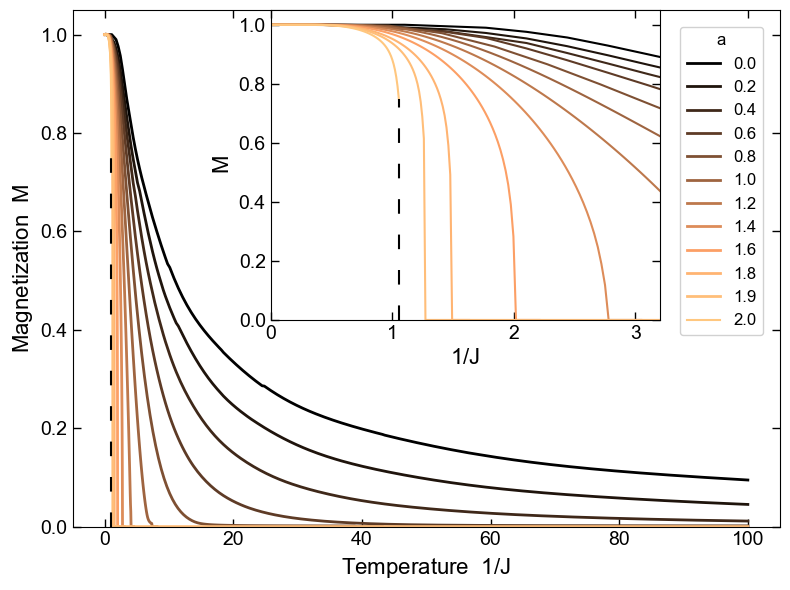

In [7]:
# Plot loaded data
from matplotlib import cm

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'mathtext.default': 'regular'})

fig, ax = plt.subplots(figsize=(8, 6))
cmap = cm.copper
norm = plt.Normalize(a_values.min(), a_values.max())

# Main plot
for a, tuples_a in zip(a_values, data_by_a):
    T_arr = np.array([x[0] for x in tuples_a])
    M_arr = np.array([x[1] for x in tuples_a])
    if a != max(a_values):
        ax.plot(T_arr, M_arr, label=f"{a:.1f}", color=cmap(norm(a)), linewidth=2)
    else:
        i = np.where(T_arr==1.054473426129e+00)[0][0]
        ax.plot(T_arr[:i+1], M_arr[:i+1], marker='', label=f'{a:.1f}', color=cmap(norm(a)), linewidth=1.5)
        ax.plot([T_arr[i], T_arr[i]], [0, M_arr[i]], linestyle='--', dashes=(7, 10), color='k', linewidth=1.5)

#ax.plot(Ts, Ms, label="NN", color='r', linestyle='--', linewidth=2)

# Colorbar
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#cbar = fig.colorbar(sm, ax=ax)
#cbar.set_label('Interaction range exponent $a$', fontsize=16)
#cbar.ax.tick_params(labelsize=14) 

ax.set_xlabel('Temperature  $1/J$', fontsize=16)
ax.set_ylabel('Magnetization  $M$', fontsize=16)
#ax.set_xlim(0, 80)
ax.set_ylim(0, 1.05)
ax.legend(title=r'$a$', title_fontsize=12, borderaxespad=1, loc=1, fontsize=12, framealpha=.9) # loc=(0.18, 0.5)
ax.tick_params(axis='both', which='major', direction='in', top=True, right=True, labelsize=14, width=1, length=6)

# --- Inset axis (upper right) ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#inset = inset_axes(ax, width="50%", height="60%", loc=(0.5, 0.5), bbox_to_anchor=None, bbox_transform=None,)

# x0,y0,w,h are in parent-axes fraction coords (0..1)
x0, y0, w, h = 0.28, 0.4, 0.55, 0.6
inset = inset_axes(ax, width="100%", height="100%",
                    bbox_to_anchor=(x0, y0, w, h),
                    bbox_transform=ax.transAxes,
                    loc="lower left",
                    borderpad=0.0,)

# Plot into inset
for a, tuples_a in zip(a_values, data_by_a):
    T_arr = np.array([x[0] for x in tuples_a])
    M_arr = np.array([x[1] for x in tuples_a])
    if a != max(a_values):
        inset.plot(T_arr, M_arr, color=cmap(norm(a)), linewidth=1.5)
    else:
        #i = np.where(T_arr==1.054473426129e+00)[0][0]
        inset.plot(T_arr[:i+1], M_arr[:i+1], marker='', label=f'{a:.2f}', color=cmap(norm(a)), linewidth=1.5)
        inset.plot([T_arr[i], T_arr[i]], [0, M_arr[i]], linestyle='--', dashes=(7, 10), color='k', linewidth=1.5)

#inset.plot(Ts, Ms, label="NN", color='r', linestyle='--', linewidth=1.5)

# Set x-axis limits for zoom
inset.set_xlabel('$1/J$', fontsize=16)
inset.set_ylabel('$M$', fontsize=16)
inset.set_xlim(0, 3.2)
inset.set_ylim(0, 1.05)
inset.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=14, width=1, length=6)

plt.tight_layout()
#plt.savefig("../figures/magnetization.png")
plt.show()